In [1]:
import sys
from dhg import Hypergraph
from hypgs.models.hsn_pyg import HSN
from hypgs.utils.data import HGDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import random_split
from pytorch_lightning.loggers import TensorBoardLogger
from hypgs import DATA_DIR
import anndata
import os
import torch
import numpy as np
import phate
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
import random 
from torch_geometric.utils.convert import from_networkx
from importlib import reload
from hypgs.models.hsn_pyg import HyperScatteringModule
from einops import rearrange

## Data import and loading

Load in the data and do some preprocessing to ensure that only genes present in both dataset are used. Additionally, specify the handpicked markers from Holly

In [2]:
data_path = os.path.join(DATA_DIR, 'spatial_data', 'A23-290-CP_anndata.h5ad')
cell_data = anndata.read_h5ad(data_path)
print(cell_data)

data_path_diseased = os.path.join(DATA_DIR, 'spatial_data', 'YA-7-CP_anndata.h5ad')
cell_data_diseased = anndata.read_h5ad(data_path_diseased)
print(cell_data_diseased)

AnnData object with n_obs × n_vars = 21331 × 16662
    obsm: 'X_spatial', 'spatial'
AnnData object with n_obs × n_vars = 58459 × 24931
    obsm: 'X_spatial', 'spatial'


In [3]:
shared_elements = cell_data.var_names.intersection(cell_data_diseased.var_names)
print(shared_elements)

cell_data = cell_data[:, cell_data.var_names.isin(shared_elements)]
cell_data_diseased = cell_data_diseased[:, cell_data_diseased.var_names.isin(shared_elements)]

print(cell_data)
print(cell_data_diseased)

Index(['HNRNPA3P13', 'CDH13', 'MS4A18', 'LINC01515', 'LARP4B-DT', 'RPS3AP51',
       'FBXW8', 'PPIAP7', 'DUSP5-DT', 'SLC6A9',
       ...
       'TPRXL', 'RPSAP61', 'PAX3', 'TDRD12', 'WHAMMP2', 'DNAH17-AS1',
       'LINC01276', 'BIK', 'RPL12P17', 'IL33'],
      dtype='object', length=15987)
View of AnnData object with n_obs × n_vars = 21331 × 15987
    obsm: 'X_spatial', 'spatial'
View of AnnData object with n_obs × n_vars = 58459 × 15987
    obsm: 'X_spatial', 'spatial'


Define relevant genes and make subsets based on Holly's recs

In [4]:
epithelial_cell_markers = ['MUC1', 'EPCAM', 'CDH1']
'''
mucin 1 (MUC1) aka epithelial membrane antigen (EMA)
epithelial cell adhesion molecule (Ep-CAM), also known as CD326
E-cadherin (CDH1)
____alternatives____
polymorphic epithelial mucin (PEM)

'''
pericyte_markers = ['PDGFRB', 'PECAM1', 'CSPG4']

'''
PECAM1 aka CD31 platelet and endothelial cell adhesion molecule, excludes endothelial cells
CSPG4 chondroitin sulfate proteoglycan 4 [ (human)]
'''

#____Immune_markers____


pan_Tcell_markers = ['CD3E', 'CD3D']
#All T cells express CD3, which has subunits encoded by different genes (delta, epsilon, zeta)

CD4_Tcell_markers = ['CD4']
# subsets
Teff =  ['IFNG','TNF','CXCR3','TBX21']
Treg =  ['IL10','TGFB1','IL7R','IL2RA', 'CTLA4', 'FOXP3']
Tfh = ['BCL6', 'PDCD1', 'CXCR5']

CD8_Tcell_markers = ['CD8A']
# subsets
Teff =  ['KLRG1', 'IFNG', 'TNF','CXCR3','TBX21']
Texhausted = ['PDCD1','LAG3','CTLA4','TIM3']
Tmem = ['IL7R', 'CD45RO', 'EOMES']
Trm = ['SELL', 'CD69', 'ITGAE', 'ITGA1', 'CCR7', 'SIPR1']

In [5]:
all_markers = epithelial_cell_markers + pericyte_markers + pan_Tcell_markers + CD4_Tcell_markers + CD8_Tcell_markers
all_subsets = Teff + Treg + Tfh + Teff + Texhausted + Tmem + Trm

all_markers_and_subsets = all_markers + all_subsets
print('There are {} markers and subsets in total'.format(len(all_markers_and_subsets)))
print(all_markers_and_subsets)

cell_data_markers = cell_data[:, cell_data.var_names.isin(all_markers_and_subsets)]
cell_data_diseased_markers = cell_data_diseased[:, cell_data_diseased.var_names.isin(all_markers_and_subsets)]

# check to see which var_names in all_markers_and_subsets are not in cell_data_markers
missing_markers = [marker for marker in all_markers_and_subsets if marker not in cell_data_markers.var_names]
print(f"there are {len(missing_markers)} missing markers in cell_data_markers")
print(missing_markers)

print(cell_data_markers)
print(cell_data_diseased_markers)

There are 42 markers and subsets in total
['MUC1', 'EPCAM', 'CDH1', 'PDGFRB', 'PECAM1', 'CSPG4', 'CD3E', 'CD3D', 'CD4', 'CD8A', 'KLRG1', 'IFNG', 'TNF', 'CXCR3', 'TBX21', 'IL10', 'TGFB1', 'IL7R', 'IL2RA', 'CTLA4', 'FOXP3', 'BCL6', 'PDCD1', 'CXCR5', 'KLRG1', 'IFNG', 'TNF', 'CXCR3', 'TBX21', 'PDCD1', 'LAG3', 'CTLA4', 'TIM3', 'IL7R', 'CD45RO', 'EOMES', 'SELL', 'CD69', 'ITGAE', 'ITGA1', 'CCR7', 'SIPR1']
there are 15 missing markers in cell_data_markers
['IFNG', 'TNF', 'CXCR3', 'IL10', 'FOXP3', 'PDCD1', 'CXCR5', 'IFNG', 'TNF', 'CXCR3', 'PDCD1', 'TIM3', 'CD45RO', 'CCR7', 'SIPR1']
View of AnnData object with n_obs × n_vars = 21331 × 23
    obsm: 'X_spatial', 'spatial'
View of AnnData object with n_obs × n_vars = 58459 × 23
    obsm: 'X_spatial', 'spatial'


In [6]:
# check if all_markers_and_subsets has any duplicates
print(len(all_markers_and_subsets))
print(len(set(all_markers_and_subsets)))

# ah ok so the discrepancy comes from duplicates in all_markers_and_subsets


42
34


## Define functions to generate the scattering features

In [7]:
def get_graph(cell_data, K = 10):
    # function to get the graph from the spatial data
    sparseA = kneighbors_graph(cell_data.obsm['spatial'], K, mode='connectivity', include_self=False)
    A = sparseA.toarray()
    G = nx.from_numpy_array(A)
    return G 

def get_hyperedge_reps(model, cell_data, G, features='full_seq_phate'):
    '''
    Extracts hyperedge representations based on the given features.

    Parameters:
        model (object): Hyperscattering module for extracting hyperedge representations.
        cell_data (object): Anndata object.
        G (object): Networkx graph object.
        features (str): The type of features to use for the hypergraph nodes.
            Options: 'full_seq_phate', 'cd45', 'rand_dirac', 'other'.
            - 'full_seq_phate': PHATE on the full sequence matrix.
            - 'cd45': CD45 expression.
            - 'rand_dirac': Random dirac delta functions.
            - 'other': Use the entire matrix as features.

    Returns:
        hyperedge_reps (array): The hyperedge representations.
    '''
    if features == 'full_seq_phate':
        X_sparse = cell_data.X  # Extract the sparse matrix
        # Convert the sparse matrix to a dense matrix
        X_dense = X_sparse.toarray()
        # Run PHATE on the dense matrix
        phate_operator = phate.PHATE(n_components=10)
        phate_result = phate_operator.fit_transform(X_dense)
        node_features = phate_result
    elif features == 'cd45':
        cd45_expression = cell_data[:, cell_data.var_names == 'PTPRC']
        node_features = cd45_expression.X.toarray()
    elif features == 'rand_dirac':
        n_feat = 10
        n_cells = cell_data.X.shape[0]
        n = 100  # Change this value to the number of 1s you want in each column
        node_features = torch.zeros(n_cells, n_feat)

        for j in range(n_feat):
            indices = random.sample(range(n_cells), n)
            for index in indices:
                node_features[index][j] = 1
    else:
        node_features = cell_data.X.toarray()

    data = from_networkx(G)
    data.x = torch.tensor(node_features, dtype=torch.float)
    original_dataset = [data]
    # change k to 2 to reduce identical k-hop neighborhoods
    k = 1
    to_hg_func = lambda g: Hypergraph.from_graph_kHop(g, k)
    dataset = HGDataset(original_dataset, to_hg_func)    

    # node features are not returned
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    _, edge_feat = model(dataset[0].x.float().to(device), dataset[0].edge_index.to(device), hyperedge_attr = dataset[0].edge_attr.to(device))

    return edge_feat.cpu().detach().numpy(), dataset


In [8]:
def get_hyperedge_statistics(dataset, feature_names = None):
    # dataset is a HGDataset object. 
    N = len(dataset)
    hyperedge_statistics = {}
    for ind in range(N):
        # get the average, median, max, standard deviation, and minimum 
        # corresponding to the data in each hyperedge 
        hg_data = dataset[ind]
        hg_edge_index = hg_data.edge_index
        num_hyperedges = hg_edge_index[1, -1] + 1 # indexing of hyperedges begins at 0
        num_features = hg_data.x.shape[1]
        statistics = torch.zeros((num_hyperedges, num_features, 5))
        for i in range(num_hyperedges):
            nodes = hg_edge_index[:,hg_edge_index[1,:] == i][0,:] 
            hyperedge_data = hg_data.x[nodes]
            statistics[i, :, 0] = torch.mean(hyperedge_data, dim=0)
            statistics[i, :, 1] = torch.median(hyperedge_data, dim=0).values
            statistics[i, :, 2] = torch.max(hyperedge_data, dim=0).values
            statistics[i, :, 3] = torch.std(hyperedge_data, dim=0)
            statistics[i, :, 4] = torch.min(hyperedge_data, dim=0).values
        statistics = rearrange(statistics, 'a b c -> a (b c)')
        statistics_names = []
        if feature_names is None:
            for j in range(num_features):
                statistics_names.append(f"Feature {j + 1} Mean")
                statistics_names.append(f"Feature {j + 1} Median")
                statistics_names.append(f"Feature {j + 1} Max")
                statistics_names.append(f"Feature {j + 1} Std")
                statistics_names.append(f"Feature {j + 1} Min")
        else:
            assert len(feature_names) == num_features
            for j in range(num_features):
                statistics_names.append(f"{feature_names[j]} Mean")
                statistics_names.append(f"{feature_names[j]} Median")
                statistics_names.append(f"{feature_names[j]} Max")
                statistics_names.append(f"{feature_names[j]} Std")
                statistics_names.append(f"{feature_names[j]} Min")
        hyperedge_statistics[ind] = (statistics, statistics_names)

    return hyperedge_statistics
        
    

In [9]:
# plotter function
def plot_hypergraph_features_2d(edge_feat, K = 5):
    # Perform PHATE on the edge features
    phate_operator = phate.PHATE(n_components=2)
    phate_result = phate_operator.fit_transform(edge_feat)
    clusters = phate.cluster.kmeans(phate_operator, k=K)

    # Plot the edge features using PHATE
    scatter = plt.scatter(phate_result[:, 0], phate_result[:, 1], c=clusters, cmap='viridis')

    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Cluster")
    # turn of axis ticks
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('PHATE 1')
    plt.ylabel('PHATE 2')
    plt.title('Hyperedge Embeddings')

    plt.show()

    return phate_result, clusters

def plot_hypergraph_features_3d(edge_feat, K = 5):
    # Perform PHATE on the edge features
    phate_operator = phate.PHATE(n_components=3)
    phate_result = phate_operator.fit_transform(edge_feat)
    clusters = phate.cluster.kmeans(phate_operator, k=K)
    # Plot the edge features using PHATE
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(phate_result[:, 0], phate_result[:, 1], phate_result[:, 2], c=clusters, cmap='viridis')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_zlabel('PHATE 3')
    # turn off axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.title('Hyperedge Embeddings')
    # add a legend for the cluster
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Cluster")
    plt.show()

    return phate_result, clusters

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def train_decision_tree(data, clusters, max_depth = 2):
    # Extract the features and labels from the data
    features = data # before this used to be data.X
    labels = clusters

    # Create a decision tree classifier, with max depth 2
    clf  = DecisionTreeClassifier(max_depth= max_depth)

    # Train the decision tree classifier
    clf.fit(features, labels)

    return clf


## Experiment with the slideSeq alzheimers data

In [29]:
cell_data_tiny.obsm['spatial']

ArrayView([[-2450.4,  5256.9],
           [-4220. ,  5496. ],
           [-5080.3,  1379. ],
           [-1301.6,  4906.1],
           [-2091.7,  4056.1],
           [-2042.2,  4229.4],
           [-2090.6,  2512. ],
           [-2739.6,   868. ],
           [-1413.4,  3449.2],
           [-1535.9,  3524.6],
           [-3474.9,  4562.9],
           [-2307.9,  4987.6],
           [-3495.2,  1062. ],
           [-2726.2,  2256. ],
           [-2837.5,  4300. ],
           [-2923.6,  5271.6],
           [-3220.6,  4459.3],
           [-3190.4,  4822.7],
           [-3584.6,  4768.7],
           [-1657.4,  5171. ],
           [ -910.8,  4445.4],
           [-2151.5,  1631.4],
           [-1634.6,  5249.4],
           [-3529.1,  2573.2],
           [-1510. ,  2913.4],
           [-1327.5,  4188.4],
           [-3863.1,  3560.5],
           [-3159.4,  4471.4],
           [-5094.2,  5307.7],
           [-2432.1,  3782. ],
           [-3540.2,  4852.7],
           [-2734. ,   912. ],
        

Calculating PHATE...
  Running PHATE on 100 observations and 15987 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (100, 15987) is expensive. Consider setting n_pca.
  warnings.warn(


    Calculated KNN search in 0.25 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.28 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.12 seconds.
Calculated PHATE in 0.40 seconds.


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
Converting to hypergraph data: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s]

(1, 6, 90, 10)
Calculating PHATE...
  Running PHATE on 90 observations and 60 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 28
  Calculating diffusion potential...
  Calculating metric MDS...



/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 0.05 seconds.
Calculated PHATE in 0.07 seconds.


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/phate/cluster.py:57: FutureWarning: k is deprecated. Please use n_clusters in future.
  warnings.warn(
/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


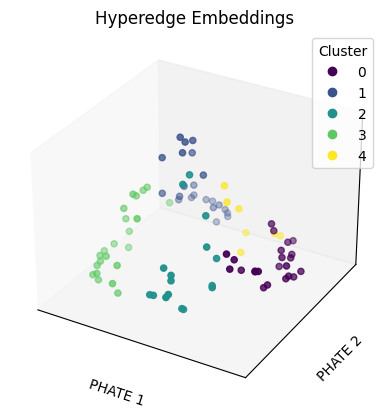

ValueError: 'c' argument has 90 elements, which is inconsistent with 'x' and 'y' with size 100.

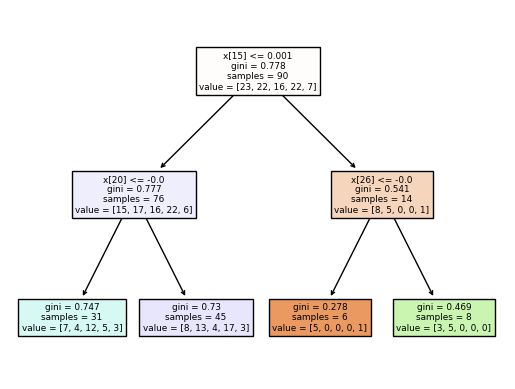

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HyperScatteringModule(in_channels=1, # doesn't matter here.
            trainable_laziness = False,
            trainable_scales = False, 
            activation = None, # just get one layer of wavelet transform 
            fixed_weights=True, 
            normalize='right', 
            reshape=False,
    ).to(device)

# do everything on a subset of the data called tiny
cell_data_tiny = cell_data[:100, :]
G = get_graph(cell_data_tiny, K = 5)
edge_feat, dataset = get_hyperedge_reps(model, cell_data_tiny, G, features='full_seq_phate')
print(edge_feat.shape)
edge_feat = edge_feat.reshape(edge_feat.shape[2], -1)
phate_result, clusters = plot_hypergraph_features_3d(edge_feat, K = 5)
hyperedge_stats = get_hyperedge_statistics(dataset)

clf = train_decision_tree(hyperedge_stats[0][0].numpy(), clusters)
tree.plot_tree(clf, filled=True)

# visualize the spatial coordinates and color by cluster
spatial = cell_data_tiny.obsm['spatial']
# generate handles and labels 
scatter = plt.scatter(spatial[:, 0], spatial[:, 1], c=clusters, cmap='viridis')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Cluster")
plt.title('Spatial Embeddings')
plt.show()




In [31]:
dataset

HGDataset()

Converting to hypergraph data: 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]

(1, 6, 14662, 23)
Calculating PHATE...
  Running PHATE on 14662 observations and 138 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


    Calculated PCA in 0.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 28.47 seconds.
    Calculating affinities...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 12855 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 6.13 seconds.
  Calculated graph and diffusion operator in 34.85 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.92 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.40 seconds.
  Calculated landmark operator in 12.28 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 3.54 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.50 seconds.
  Calculating metric MDS...


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 116.00 seconds.
Calculated PHATE in 167.18 seconds.


/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/phate/cluster.py:57: FutureWarning: k is deprecated. Please use n_clusters in future.
  warnings.warn(
/home/sumry2023_cqx3/.conda/envs/hyper/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


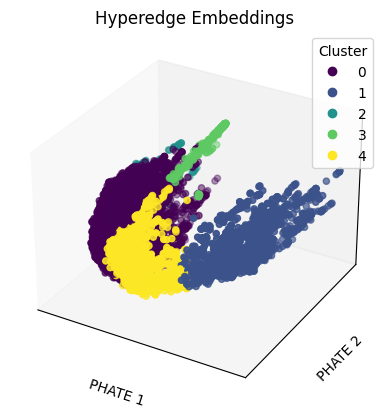

View of AnnData object with n_obs × n_vars = 21331 × 23
    obsm: 'X_spatial', 'spatial'
View of AnnData object with n_obs × n_vars = 58459 × 23
    obsm: 'X_spatial', 'spatial'


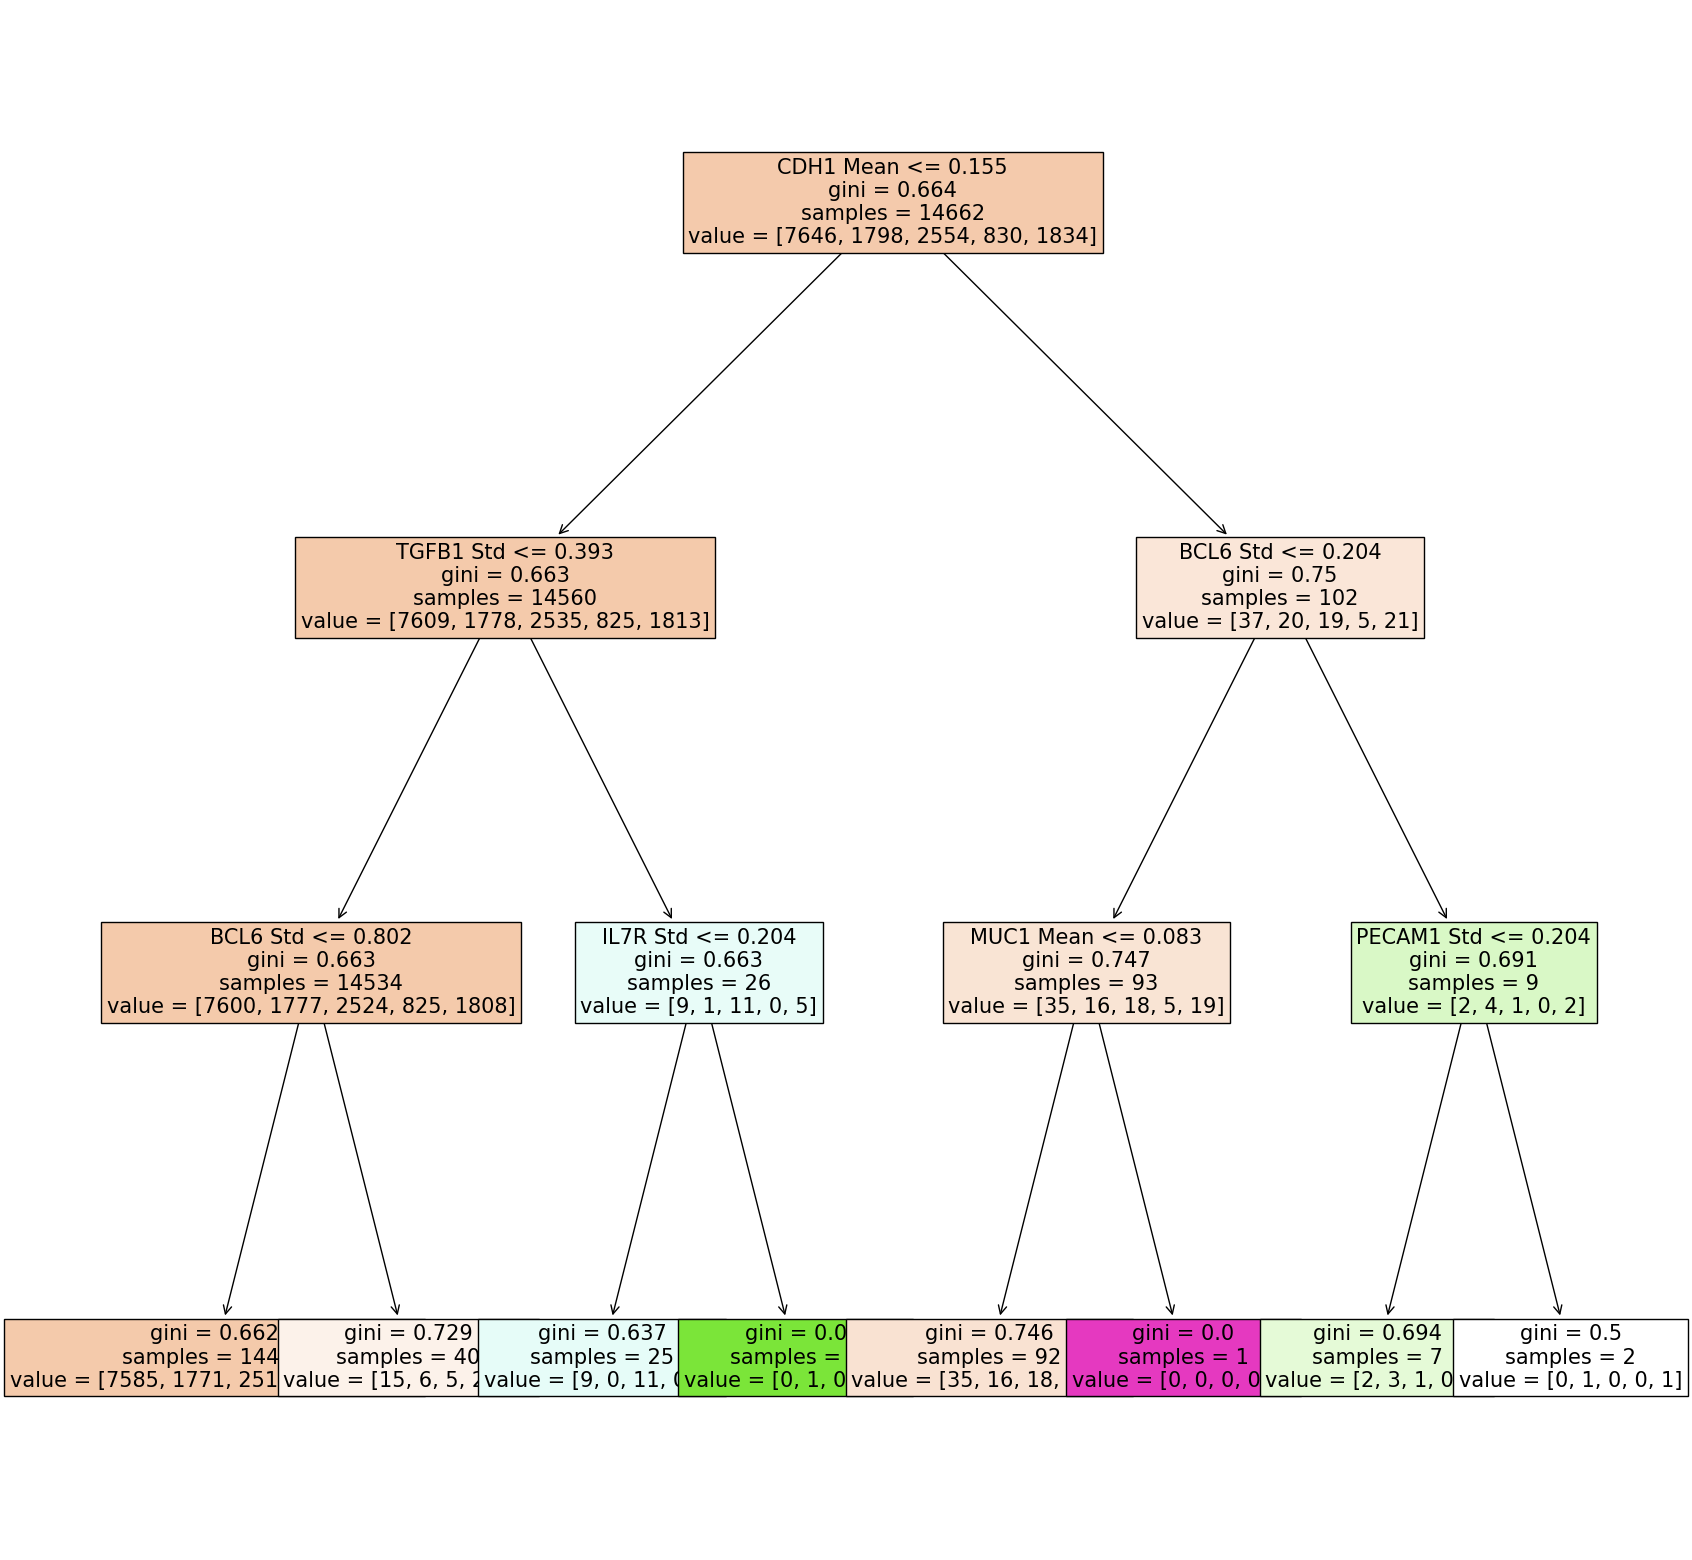

In [28]:
# Experiment using markers

model = HyperScatteringModule(in_channels=1, # doesn't matter here.
            trainable_laziness = False,
            trainable_scales = False, 
            activation = None, # just get one layer of wavelet transform 
            fixed_weights=True, 
            normalize='right', 
            reshape=False,
    ).to(device)

# do everything on a subset of the data called tiny
cell_data_tiny = cell_data_markers[:15000, :]
G = get_graph(cell_data_tiny, K = 5)
edge_feat, dataset = get_hyperedge_reps(model, cell_data_tiny, G, features='other')
print(edge_feat.shape)
edge_feat = edge_feat.reshape(edge_feat.shape[2], -1)
phate_result, clusters = plot_hypergraph_features_3d(edge_feat, K = 5)
hyperedge_stats = get_hyperedge_statistics(dataset, cell_data_markers.var_names)

clf = train_decision_tree(hyperedge_stats[0][0].numpy(), clusters, max_depth = 3)
names = hyperedge_stats[0][1]

plt.figure(figsize=(20,20))
tree.plot_tree(clf, 
               feature_names = names, 
               fontsize = 15,
               filled=True)
plt.savefig('decision_tree_markers.png', dpi = 300, bbox_inches='tight')
plt.show

print(cell_data_markers)
print(cell_data_diseased_markers)